#### Importing Packages and Loading Data

In [1]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [2]:
# Load the CSV file
train_csv_path = './data/train.csv'
train_df = pd.read_csv(train_csv_path)

train_df.head()

,Text,Image
0,lounes,./data/train/train_000001.png
1,camalayarane,./data/train/train_000002.png
2,roy,./data/train/train_000003.png
3,munch,./data/train/train_000004.png
4,pierre,./data/train/train_000005.png


In [3]:
# Getting image path
image_paths = [f"./data/train/{file}" for file in os.listdir("./data/train")]

### Basic EDA on the dataset

In [4]:
# Summary statistics
train_df.describe()

,Text,Image
count,2000,2000
unique,2000,2000
top,lounes,./data/train/train_000001.png
freq,1,1


In [5]:
# Check for missing values
train_df.isnull().sum()

Text     0
Image    0
dtype: int64

In [6]:
# Distribution of text lengths
train_df['text_length'] = train_df['Text'].apply(len)
text_length_distribution = train_df['text_length'].describe()
text_length_distribution

count    2000.0
mean       19.0
std         0.0
min        19.0
25%        19.0
50%        19.0
75%        19.0
max        19.0
Name: text_length, dtype: float64

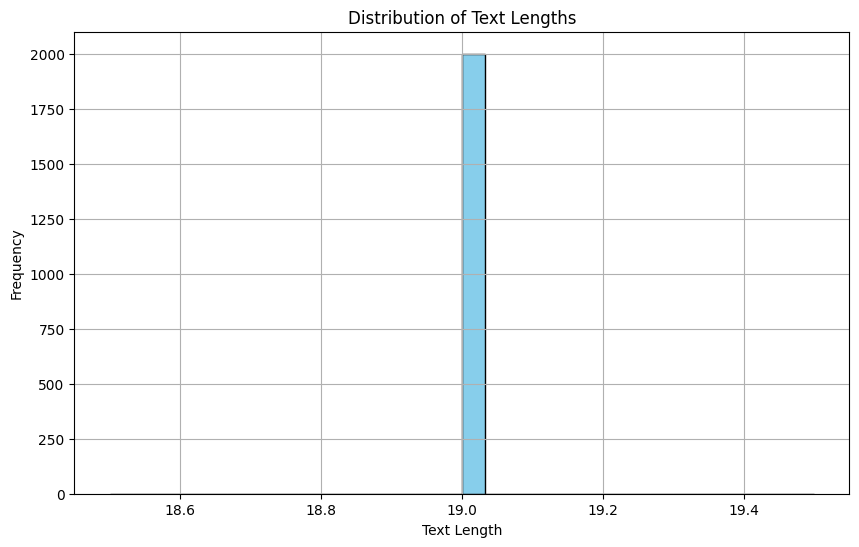

In [7]:
# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

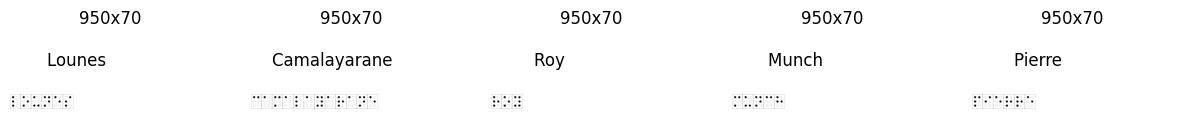

In [8]:
# Load and display the first few images with their dimensions
plt.figure(figsize=(15, 10))

for i, img_path in enumerate(image_paths[:5]):
    img = Image.open(img_path)
    width, height = img.size
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'{width}x{height}\n\n{train_df.iloc[i]["Text"].title()}\n')
    plt.axis('off')

plt.show()

In [9]:
# Function to get image dimensions
def get_image_dimensions(image_path):
    img = Image.open(image_path)
    return img.size

# Verify the correspondence between text length and image width
train_df['image_width'] = train_df['Image'].apply(lambda x: get_image_dimensions(x)[0])
train_df['image_height'] = train_df['Image'].apply(lambda x: get_image_dimensions(x)[1])

In [10]:
# Check if image height is consistent
consistent_height = all(train_df['image_height'] == 70)
print(f"\nAll images have consistent height of 70 pixels: {consistent_height}")

# Calculate expected width
train_df['expected_width'] = train_df['text_length'] * 50

# Check for discrepancies between actual and expected width
width_discrepancies = (train_df['image_width'] != train_df['expected_width']).sum()
print(f"\nNumber of discrepancies between actual and expected image widths: {width_discrepancies}")


All images have consistent height of 70 pixels: True

Number of discrepancies between actual and expected image widths: 0


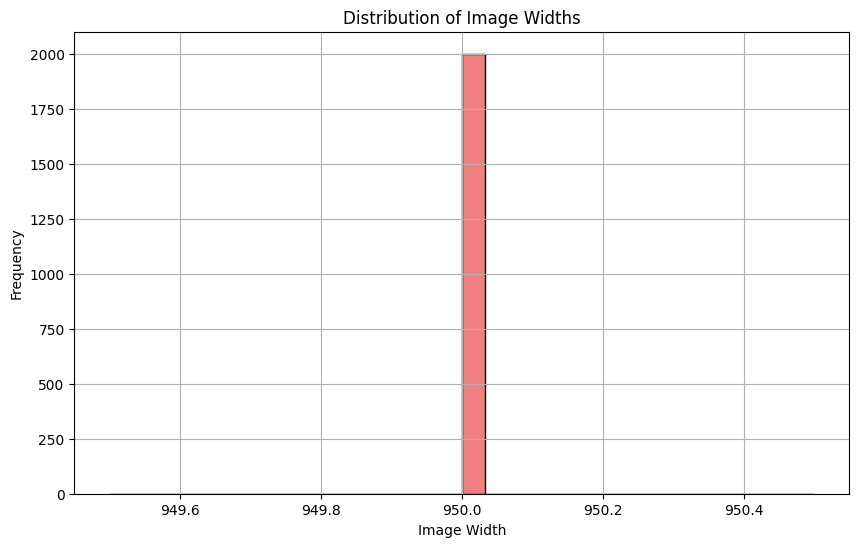

In [11]:
# Plot the distribution of image widths
plt.figure(figsize=(10, 6))
plt.hist(train_df['image_width'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Image Width')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [12]:
train_df.head()

,Text,Image,text_length,image_width,image_height,expected_width
0,lounes,./data/train/train_000001.png,19,950,70,950
1,camalayarane,./data/train/train_000002.png,19,950,70,950
2,roy,./data/train/train_000003.png,19,950,70,950
3,munch,./data/train/train_000004.png,19,950,70,950
4,pierre,./data/train/train_000005.png,19,950,70,950


In [13]:
def pad_words_in_csv(csv_file, max_length=19):
    df = pd.read_csv(csv_file)
    df['Text'] = df['Text'].apply(lambda x: x.ljust(max_length))
    df.to_csv(csv_file, index=False)

# Paths to CSV files
train_csv = "./data/train.csv"
validation_csv = "./data/validation.csv"
test_csv = "./data/test.csv"

# Preprocess CSV files to pad words
pad_words_in_csv(train_csv)
pad_words_in_csv(validation_csv)
pad_words_in_csv(test_csv)

In [14]:
class BrailleDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = {char: idx for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz ")}
        self.num_classes = len(self.classes)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 1].split("/")[-1])
        image = Image.open(img_name).convert('RGB')
        label = self.labels.iloc[idx, 0]
        label = torch.tensor([self.classes[char] for char in label], dtype=torch.long)  # Convert label to tensor
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Transforms for image preprocessing
transform = transforms.Compose([
    transforms.Resize((70, 950)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [15]:
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, 0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-1)  # Use -1 as padding value
    return images, labels


In [16]:
class BrailleCNN(nn.Module):
    def __init__(self, num_classes, max_label_length):
        super(BrailleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveMaxPool2d((35, 475))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 35 * 475, 128)
        self.fc2 = nn.Linear(128, num_classes * max_label_length)
        self.num_classes = num_classes
        self.max_label_length = max_label_length

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 35 * 475)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, self.max_label_length, self.num_classes)  # Reshape for sequence output
        return x


In [17]:
def train_and_validate():
    # Paths
    train_csv = "./data/train.csv"
    train_images_path = "./data/train/"
    validation_csv = "./data/validation.csv"
    validation_images_path = "./data/validation/"

    # Hyperparameters
    batch_size = 128  # Increased batch size to better utilize GPU
    learning_rate = 0.001
    num_epochs = 20
    max_label_length = 19  # Maximum number of characters in labels
    num_classes = 27  # Number of classes for each alphabet letter plus space

    # Data loaders
    train_dataset = BrailleDataset(csv_file=train_csv, img_dir=train_images_path, transform=transform)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    validation_dataset = BrailleDataset(csv_file=validation_csv, img_dir=validation_images_path, transform=transform)
    validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Model, loss function, optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BrailleCNN(num_classes=num_classes, max_label_length=max_label_length).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore the padding value (-1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            
            # Flatten outputs and labels while ignoring padding
            outputs = outputs.view(-1, num_classes)
            labels = labels.view(-1)
            mask = (labels != -1)
            labels = labels[mask]
            outputs = outputs[mask]

            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        validation_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                outputs = outputs.view(-1, num_classes)
                labels = labels.view(-1)
                mask = (labels != -1)
                labels = labels[mask]
                outputs = outputs[mask]

                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        validation_loss /= len(validation_loader)
        validation_accuracy = 100 * correct / total

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Validation Loss: {validation_loss:.4f}, '
              f'Validation Accuracy: {validation_accuracy:.2f}%')

        torch.save(model.state_dict(), './braille_cnn.pth')

train_and_validate()

Epoch [1/20], Train Loss: 7.7468, Validation Loss: 2.2070, Validation Accuracy: 58.43%
Epoch [2/20], Train Loss: 1.6886, Validation Loss: 1.3221, Validation Accuracy: 66.33%
Epoch [3/20], Train Loss: 1.2593, Validation Loss: 1.1697, Validation Accuracy: 67.41%
Epoch [4/20], Train Loss: 1.1804, Validation Loss: 1.1350, Validation Accuracy: 67.49%
Epoch [5/20], Train Loss: 1.1499, Validation Loss: 1.1145, Validation Accuracy: 67.96%
Epoch [6/20], Train Loss: 1.1329, Validation Loss: 1.0999, Validation Accuracy: 68.29%
Epoch [7/20], Train Loss: 1.1148, Validation Loss: 1.0805, Validation Accuracy: 67.86%
Epoch [8/20], Train Loss: 1.0942, Validation Loss: 1.0633, Validation Accuracy: 68.49%
Epoch [9/20], Train Loss: 1.0765, Validation Loss: 1.0495, Validation Accuracy: 68.87%
Epoch [10/20], Train Loss: 1.0570, Validation Loss: 1.0328, Validation Accuracy: 69.06%
Epoch [11/20], Train Loss: 1.0405, Validation Loss: 1.0138, Validation Accuracy: 70.05%
Epoch [12/20], Train Loss: 1.0199, Valida

In [18]:
def evaluate():
    # Paths
    test_csv = "./data/test.csv"
    test_images_path = "./data/test/"

    # Hyperparameters
    max_label_length = 19  # Maximum number of characters in labels
    num_classes = 27  # Number of classes for each alphabet letter plus space

    # Load test dataset
    test_dataset = BrailleDataset(csv_file=test_csv, img_dir=test_images_path, transform=transform)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Load the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BrailleCNN(num_classes=num_classes, max_label_length=max_label_length).to(device)
    model.load_state_dict(torch.load('braille_cnn.pth'))
    model.eval()

    # Evaluate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            outputs = outputs.view(-1, num_classes)
            labels = labels.view(-1)
            mask = (labels != -1)
            labels = labels[mask]
            outputs = outputs[mask]

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

evaluate()

Accuracy: 78.61052631578947%
